In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
import glob
import random
import os
import splitfolders
from tensorflow.keras.utils import to_categorical
import segmentation_models_3D as sm
import matplotlib.pyplot as plt
import keras

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, Dropout
from keras.optimizers import Adam
from keras.metrics import MeanIoU


Segmentation Models: using `tf.keras` framework.


In [6]:
TRAIN_DATASET_PATH = '..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355\\BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())

test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355\\BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355\\BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355\\BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355\\BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

1854.603271484375


In [7]:
print(np.unique(test_mask))
test_mask[test_mask==4] = 3
print(np.unique(test_mask)) 

[0 1 2 4]
[0 1 2 3]


In [4]:
n_slice=random.randint(0, test_mask.shape[2])

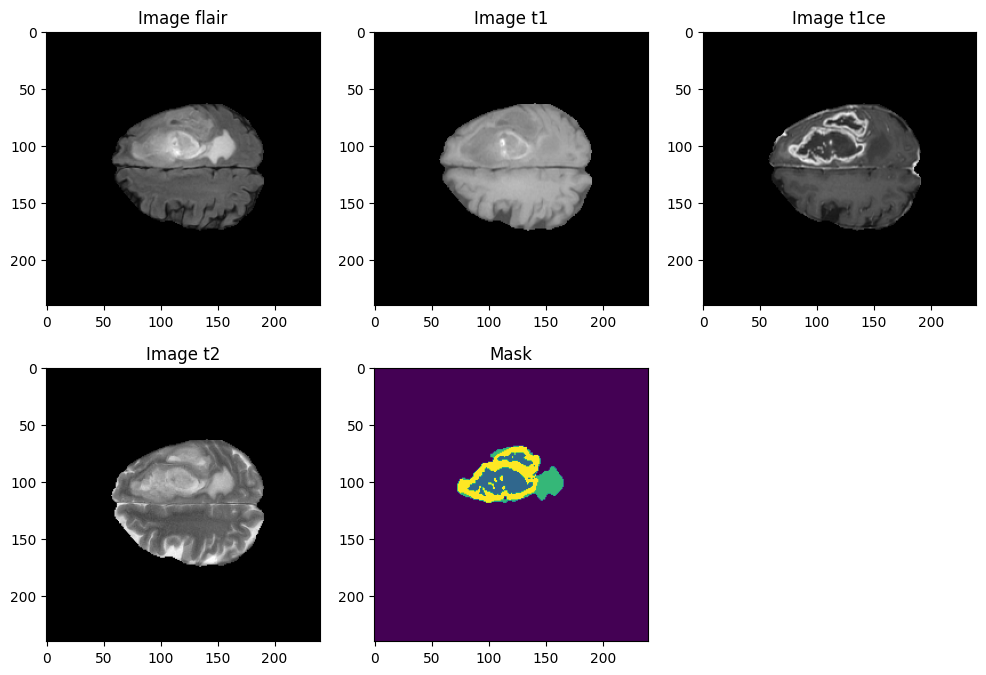

In [5]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [12]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

combined_x = combined_x[56:184, 56:184, 13:141]

test_mask = test_mask[56:184, 56:184, 13:141]



In [15]:
n_slice = random.randint(0, test_mask.shape[2])

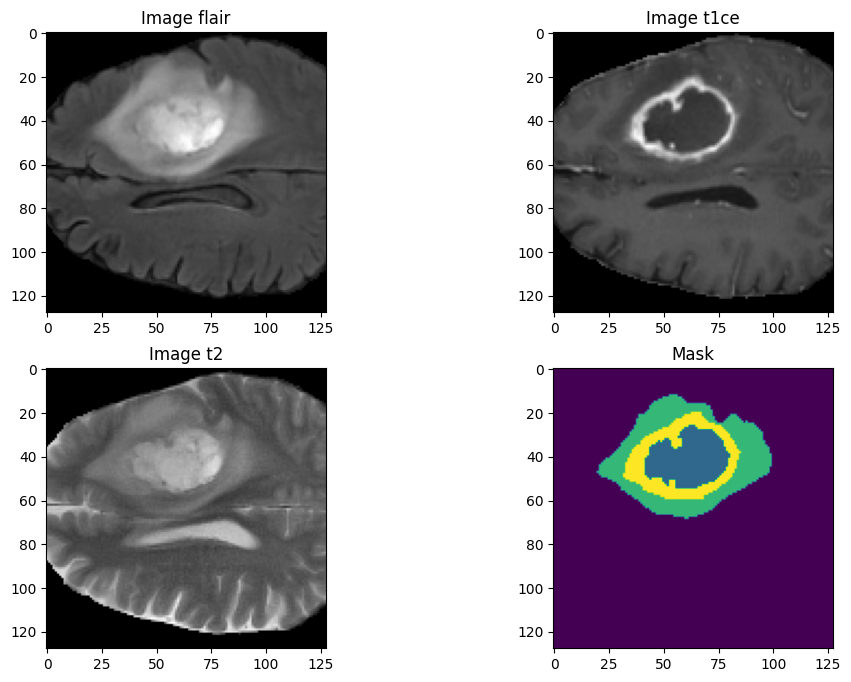

In [16]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [17]:

np.save('..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\combined255.npy', combined_x)


test_mask = to_categorical(test_mask, num_classes=4)

t2_list = sorted(glob.glob('..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\*\\*t2.nii'))
t1ce_list = sorted(glob.glob('..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\*\\*t1ce.nii'))
flair_list = sorted(glob.glob('..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\*\\*flair.nii'))
mask_list = sorted(glob.glob('..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\*\\*seg.nii'))

In [159]:
for img in range(len(t2_list)):
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01: 
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_3channels\\images\\image_'+str(img)+'.npy', temp_combined_images)
        np.save('..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_3channels\\masks\\mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print()

Now preparing image and masks number:  0
Now preparing image and masks number:  1
Now preparing image and masks number:  2
Now preparing image and masks number:  3
Now preparing image and masks number:  4

Now preparing image and masks number:  5
Now preparing image and masks number:  6
Now preparing image and masks number:  7
Now preparing image and masks number:  8
Now preparing image and masks number:  9
Now preparing image and masks number:  10
Now preparing image and masks number:  11
Now preparing image and masks number:  12
Now preparing image and masks number:  13
Now preparing image and masks number:  14
Now preparing image and masks number:  15
Now preparing image and masks number:  16
Now preparing image and masks number:  17
Now preparing image and masks number:  18
Now preparing image and masks number:  19
Now preparing image and masks number:  20
Now preparing image and masks number:  21
Now preparing image and masks number:  22
Now preparing image and masks number:  23
N

Now preparing image and masks number:  193
Now preparing image and masks number:  194
Now preparing image and masks number:  195
Now preparing image and masks number:  196
Now preparing image and masks number:  197
Now preparing image and masks number:  198
Now preparing image and masks number:  199
Now preparing image and masks number:  200
Now preparing image and masks number:  201
Now preparing image and masks number:  202
Now preparing image and masks number:  203

Now preparing image and masks number:  204
Now preparing image and masks number:  205
Now preparing image and masks number:  206
Now preparing image and masks number:  207
Now preparing image and masks number:  208
Now preparing image and masks number:  209
Now preparing image and masks number:  210
Now preparing image and masks number:  211
Now preparing image and masks number:  212
Now preparing image and masks number:  213
Now preparing image and masks number:  214
Now preparing image and masks number:  215
Now prepar

In [160]:
input_folder = '..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_3channels\\'
output_folder = '..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None)

Copying files: 688 files [1:26:20,  7.53s/ files]


In [3]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [4]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)
 
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y)

            batch_start += batch_size   
            batch_end += batch_size

In [5]:
train_img_dir = "..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\train\\images\\"
train_mask_dir = "..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\train\\masks\\"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

In [6]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)



In [7]:
n_slice=random.randint(0, test_mask.shape[2])

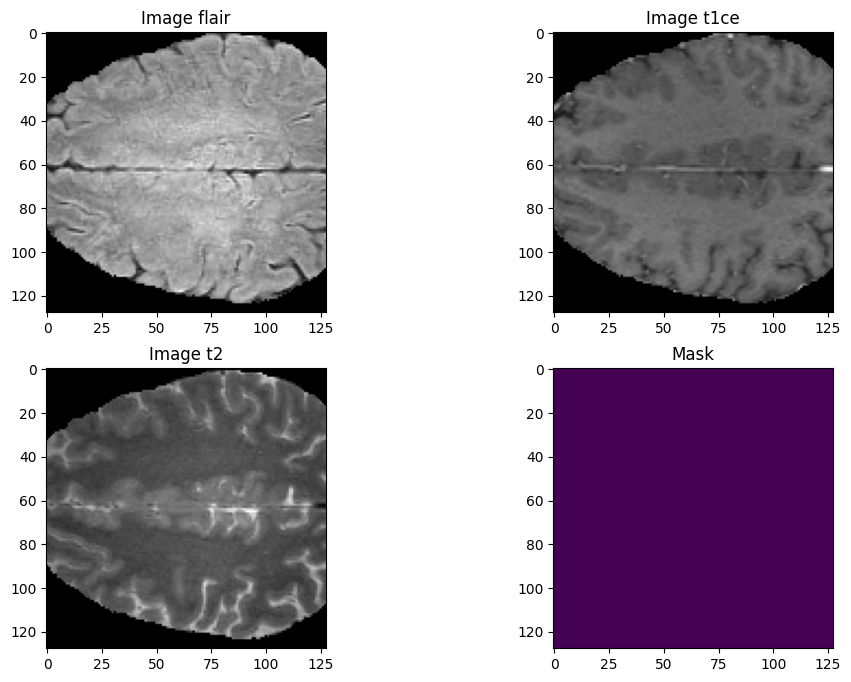

In [8]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [9]:
kernel_initializer = 'he_uniform'

In [10]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path 
    
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    
    return model

In [11]:
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

                                                                                                  
 conv3d_12 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_1[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_6 (Dropout)            (None, 32, 32, 32,   0           ['conv3d_12[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_13 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_6[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_tr

In [12]:
print(model.input_shape)

(None, 128, 128, 128, 3)


In [13]:
print(model.output_shape)

(None, 128, 128, 128, 4)


In [77]:
train_img_dir = "..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\train\\images\\"
train_mask_dir = "..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\train\\masks\\"

val_img_dir = "..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\val\\images\\"
val_mask_dir = "..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\val\\masks\\"

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [78]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

img, msk = train_img_datagen.__next__()



In [19]:
wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25

In [20]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

In [21]:
LR = 0.0001
optim = keras.optimizers.Adam(LR)

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [22]:
model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

                                                                                                  
 conv3d_31 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_5[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_15 (Dropout)           (None, 32, 32, 32,   0           ['conv3d_31[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_32 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_15[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_tr

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
model.save('models\\brats_3dupdated.hdf5')

In [ ]:
model.save('models\\brats_3d.hdf5')

In [79]:
from keras.models import load_model

In [68]:
iou_score = sm.metrics.IOUScore(threshold=0.5)

metrics = ["accuracy", iou_score]

def dice_loss_plus_1focal_loss(y_true, y_pred):
    dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
    focal_loss = sm.losses.CategoricalFocalLoss()
    return dice_loss(y_true, y_pred) + (1*focal_loss(y_true, y_pred))

co = {'iou_score': iou_score, 'dice_loss_plus_1focal_loss': dice_loss_plus_1focal_loss}

In [63]:
model = load_model(r"C:\Users\Administrator\Documents\braintumor\Unet\models\brats__3d.hdf5", custom_objects=co)

In [64]:
history = model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/25
137/137 [==============================] - 4157s 29s/step - loss: 0.8082 - accuracy: 0.9824 - iou_score: 0.6888 - val_loss: 0.8293 - val_accuracy: 0.9715 - val_iou_score: 0.6181
Epoch 2/25
137/137 [==============================] - 3970s 29s/step - loss: 0.8054 - accuracy: 0.9838 - iou_score: 0.7002 - val_loss: 0.8267 - val_accuracy: 0.9740 - val_iou_score: 0.6261
Epoch 3/25
137/137 [==============================] - 3950s 29s/step - loss: 0.8056 - accuracy: 0.9838 - iou_score: 0.6993 - val_loss: 0.8334 - val_accuracy: 0.9703 - val_iou_score: 0.6039
Epoch 4/25
137/137 [==============================] - 3946s 29s/step - loss: 0.8035 - accuracy: 0.9845 - iou_score: 0.7080 - val_loss: 0.8259 - val_accuracy: 0.9744 - val_iou_score: 0.6296
Epoch 5/25
137/137 [==============================] - 3949s 29s/step - loss: 0.8018 - accuracy: 0.9849 - iou_score: 0.7153 - val_loss: 0.8289 - val_accuracy: 0.9726 - val_iou_score: 0.6180
Epoch 6/25
137/137 [==============================] - 3

In [65]:
model.save('models\\brats_3dupdated.hdf5')

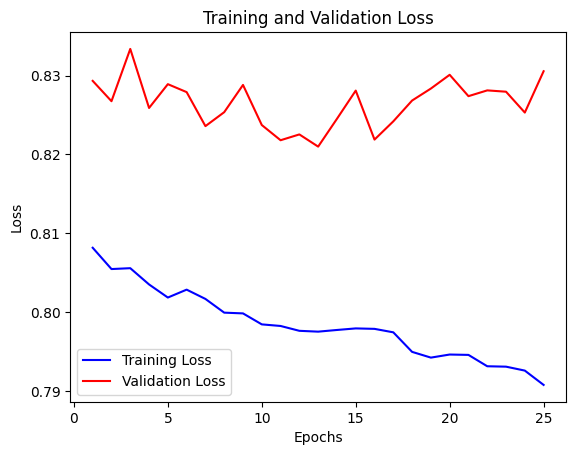

In [66]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

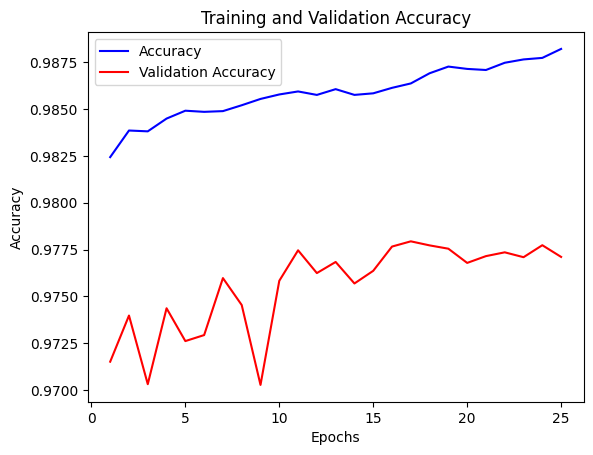

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [68]:
batch_size = 8
 
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 485s 485s/step
Mean IoU = 0.74803597


In [28]:
from tensorflow.keras.models import load_model

In [71]:
model = load_model("..\\Unet\\models\\brats_3dupdated.hdf5", compile=False)

In [80]:
img_num =82
test_img = np.load("..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\val\\images\\image_"+str(img_num)+".npy")

test_mask = np.load("..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\val\\masks\\mask_"+str(img_num)+".npy")
test_mask_argmax = np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 2s 2s/step


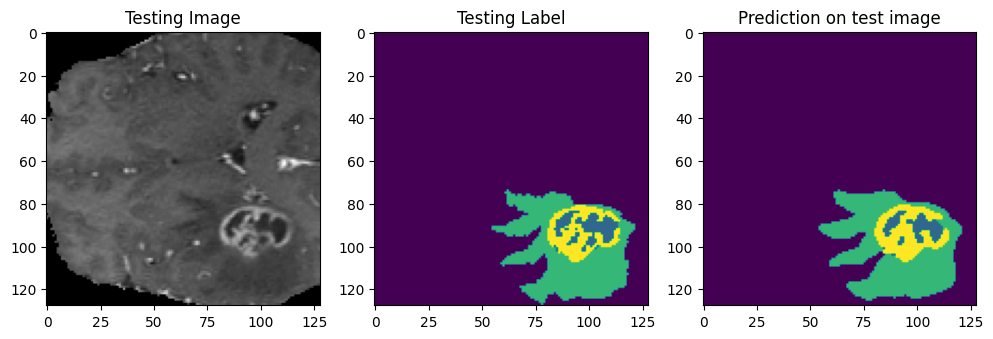

In [81]:
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [82]:
model = load_model(r"C:\Users\Administrator\Documents\braintumor\Unet\models\brats_3dupdated.hdf5", custom_objects=co)

In [84]:
history = model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/25
137/137 [==============================] - 3940s 29s/step - loss: 0.7910 - accuracy: 0.9883 - iou_score: 0.7638 - val_loss: 0.8307 - val_accuracy: 0.9761 - val_iou_score: 0.6121
Epoch 2/25
137/137 [==============================] - 3929s 29s/step - loss: 0.7898 - accuracy: 0.9886 - iou_score: 0.7691 - val_loss: 0.8284 - val_accuracy: 0.9774 - val_iou_score: 0.6255
Epoch 3/25
137/137 [==============================] - 3936s 29s/step - loss: 0.7889 - accuracy: 0.9889 - iou_score: 0.7727 - val_loss: 0.8262 - val_accuracy: 0.9781 - val_iou_score: 0.6318
Epoch 4/25
137/137 [==============================] - 3911s 29s/step - loss: 0.7891 - accuracy: 0.9887 - iou_score: 0.7724 - val_loss: 0.8253 - val_accuracy: 0.9781 - val_iou_score: 0.6322
Epoch 5/25
137/137 [==============================] - 3929s 29s/step - loss: 0.7879 - accuracy: 0.9891 - iou_score: 0.7778 - val_loss: 0.8226 - val_accuracy: 0.9789 - val_iou_score: 0.6438
Epoch 6/25
137/137 [==============================] - 3

In [85]:
model.save('models\\brats_3d75epochs.hdf5')

In [ ]:
model = load_model("..\\Unet\\models\\brats_3d75epochs.hdf5", compile=False)

In [106]:
img_num =28
test_img = np.load("..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\val\\images\\image_"+str(img_num)+".npy")

test_mask = np.load("..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\val\\masks\\mask_"+str(img_num)+".npy")
test_mask_argmax = np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 15s 15s/step


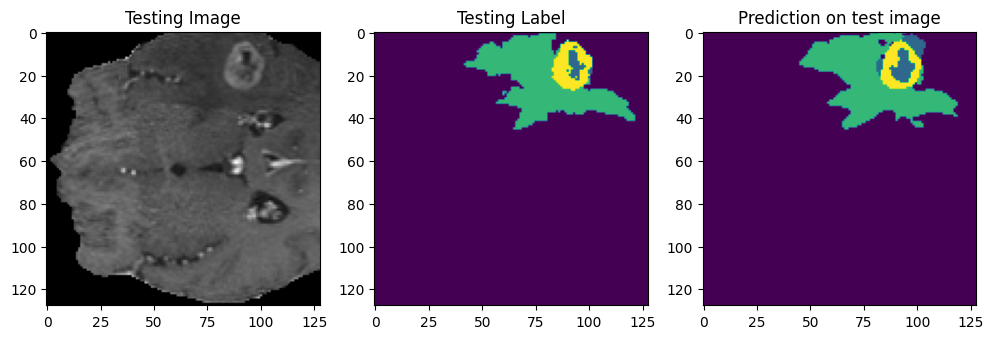

In [107]:
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

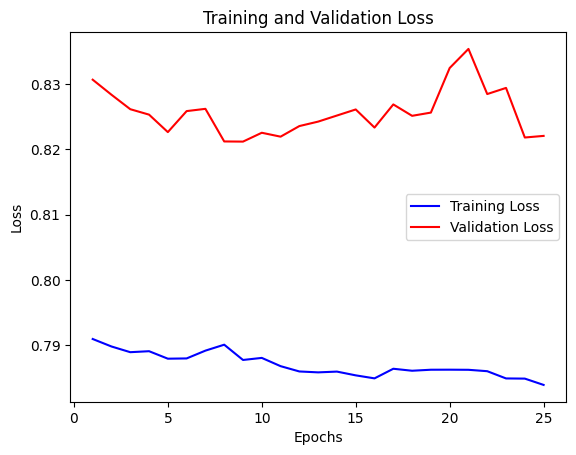

In [103]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

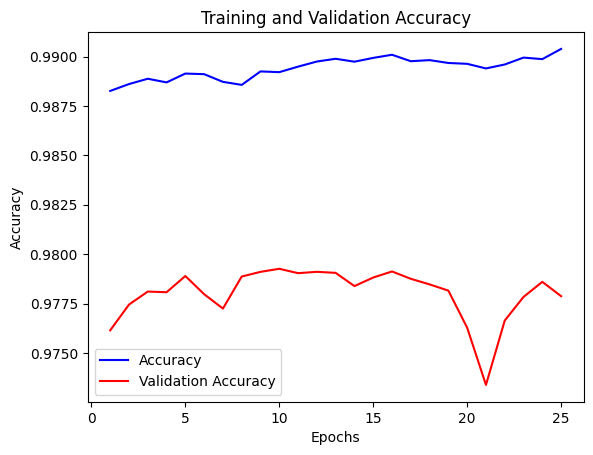

In [104]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [105]:
batch_size = 8
 
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 384s 384s/step
Mean IoU = 0.77399826


In [108]:
model = load_model(r"C:\Users\Administrator\Documents\braintumor\Unet\models\brats_3d75epochs.hdf5", custom_objects=co)

In [109]:
history = model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/10
137/137 [==============================] - 4496s 30s/step - loss: 0.7841 - accuracy: 0.9902 - iou_score: 0.7972 - val_loss: 0.8268 - val_accuracy: 0.9775 - val_iou_score: 0.6254
Epoch 2/10
137/137 [==============================] - 4057s 29s/step - loss: 0.7841 - accuracy: 0.9903 - iou_score: 0.7972 - val_loss: 0.8378 - val_accuracy: 0.9731 - val_iou_score: 0.5976
Epoch 3/10
137/137 [==============================] - 4003s 29s/step - loss: 0.7835 - accuracy: 0.9904 - iou_score: 0.8004 - val_loss: 0.8425 - val_accuracy: 0.9677 - val_iou_score: 0.5725
Epoch 4/10
137/137 [==============================] - 3996s 29s/step - loss: 0.7837 - accuracy: 0.9902 - iou_score: 0.7987 - val_loss: 0.8265 - val_accuracy: 0.9762 - val_iou_score: 0.6283
Epoch 5/10
137/137 [==============================] - 4006s 29s/step - loss: 0.7838 - accuracy: 0.9901 - iou_score: 0.7990 - val_loss: 0.8320 - val_accuracy: 0.9776 - val_iou_score: 0.6083
Epoch 6/10
137/137 [==============================] - 4

In [110]:
model.save('models\\brats_3d85epochs.hdf5')

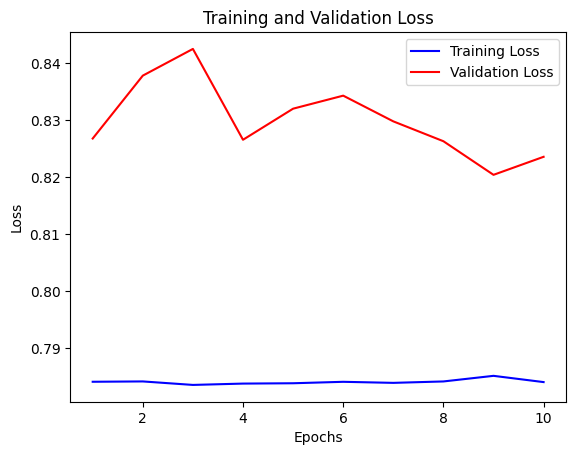

In [111]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

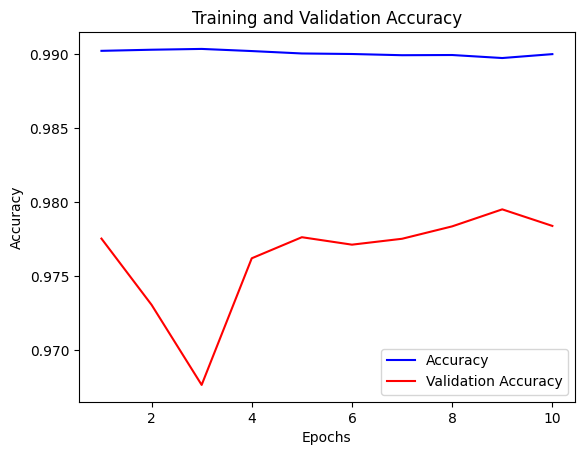

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [113]:
batch_size = 8
 
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 311s 311s/step
Mean IoU = 0.7757614


In [67]:
model = load_model(r"C:\Users\Administrator\Documents\braintumor\Unet\models\brats_3d85epochs.hdf5", custom_objects=co)

NameError: name 'co' is not defined

In [46]:
history = model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=4,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/4
137/137 [==============================] - 3978s 29s/step - loss: 0.7850 - accuracy: 0.9899 - iou_score: 0.7924 - val_loss: 0.8234 - val_accuracy: 0.9790 - val_iou_score: 0.6489
Epoch 2/4
137/137 [==============================] - 3961s 29s/step - loss: 0.7838 - accuracy: 0.9902 - iou_score: 0.7981 - val_loss: 0.8214 - val_accuracy: 0.9793 - val_iou_score: 0.6539
Epoch 3/4
137/137 [==============================] - 3922s 29s/step - loss: 0.7843 - accuracy: 0.9900 - iou_score: 0.7962 - val_loss: 0.8179 - val_accuracy: 0.9804 - val_iou_score: 0.6651
Epoch 4/4
137/137 [==============================] - 3986s 29s/step - loss: 0.7851 - accuracy: 0.9899 - iou_score: 0.7929 - val_loss: 0.8181 - val_accuracy: 0.9800 - val_iou_score: 0.6674


In [47]:
model.save('models\\brats_3d89epochs.hdf5')

In [48]:
print(model.input_shape)

(None, 128, 128, 128, 3)


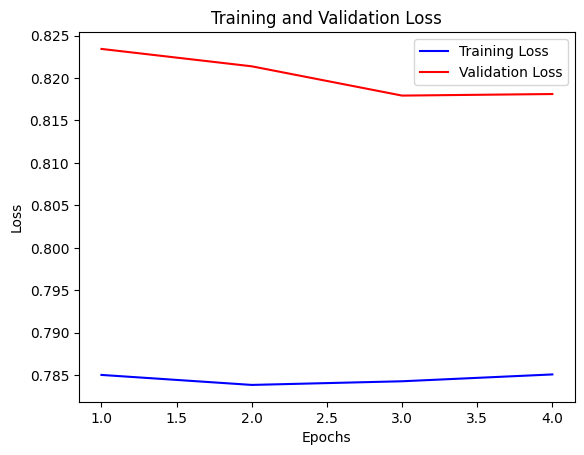

In [56]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

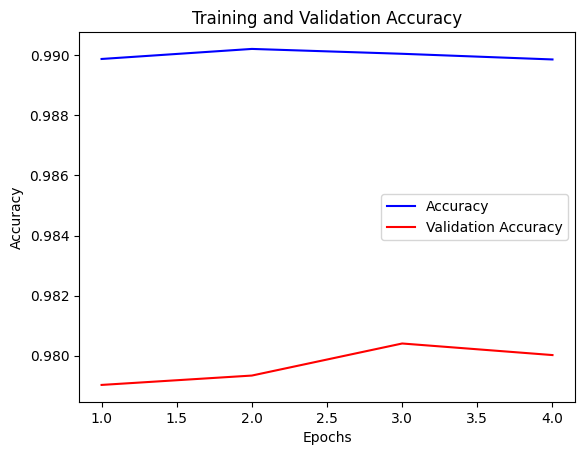

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [58]:
batch_size = 8
 
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 231s 231s/step
Mean IoU = 0.7746452


In [118]:
img_num =82
test_img = np.load("..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\val\\images\\image_"+str(img_num)+".npy")

test_mask = np.load("..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\val\\masks\\mask_"+str(img_num)+".npy")
test_mask_argmax = np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 32s 32s/step


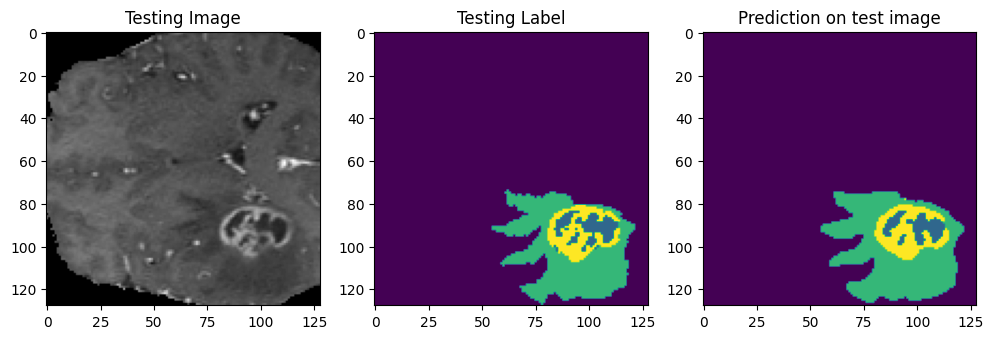

In [119]:
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [56]:
model = load_model("..\\Unet\\models\\brats_3d89epochs.hdf5", compile=False)

In [65]:
img_num =149
test_img = np.load("..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\val\\images\\image_"+str(img_num)+".npy")

test_mask = np.load("..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\val\\masks\\mask_"+str(img_num)+".npy")
test_mask_argmax = np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 2s 2s/step


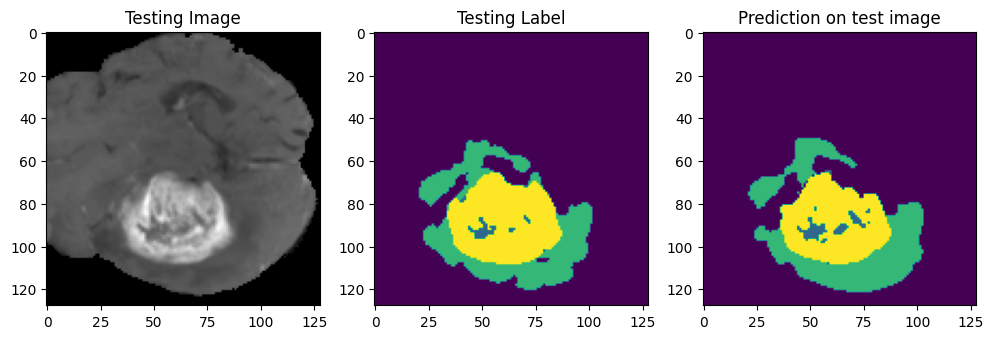

In [66]:
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [69]:
model = load_model(r"C:\Users\Administrator\Documents\braintumor\Unet\models\brats_3d85epochs.hdf5", custom_objects=co)

In [70]:
history = model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=15,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/15
137/137 [==============================] - 4224s 31s/step - loss: 0.7851 - accuracy: 0.9898 - iou_score: 0.7924 - val_loss: 0.8257 - val_accuracy: 0.9782 - val_iou_score: 0.6426
Epoch 2/15
137/137 [==============================] - 4074s 29s/step - loss: 0.7843 - accuracy: 0.9900 - iou_score: 0.7959 - val_loss: 0.8199 - val_accuracy: 0.9797 - val_iou_score: 0.6604
Epoch 3/15
137/137 [==============================] - 3999s 29s/step - loss: 0.7837 - accuracy: 0.9902 - iou_score: 0.7989 - val_loss: 0.8188 - val_accuracy: 0.9794 - val_iou_score: 0.6595
Epoch 4/15
137/137 [==============================] - 3994s 29s/step - loss: 0.7836 - accuracy: 0.9903 - iou_score: 0.8000 - val_loss: 0.8189 - val_accuracy: 0.9782 - val_iou_score: 0.6617
Epoch 5/15
137/137 [==============================] - 3979s 29s/step - loss: 0.7839 - accuracy: 0.9902 - iou_score: 0.7980 - val_loss: 0.8215 - val_accuracy: 0.9771 - val_iou_score: 0.6552
Epoch 6/15
137/137 [==============================] - 3

In [71]:
model.save('models\\brats_3d100epochs.hdf5')

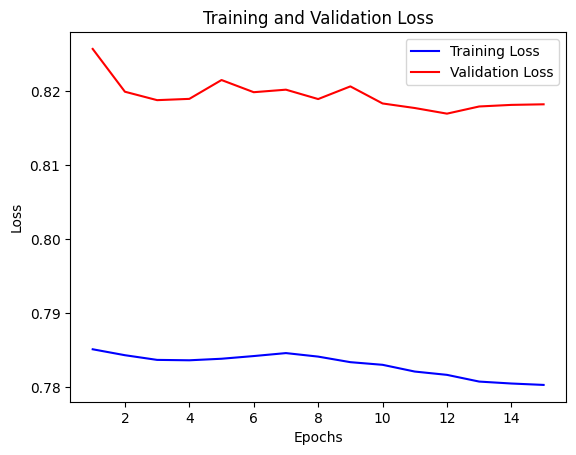

In [72]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

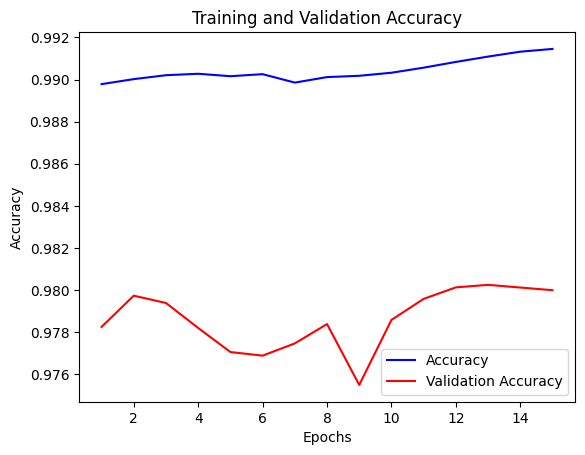

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [74]:
batch_size = 8
 
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 174s 174s/step
Mean IoU = 0.78481966


In [89]:
img_num =82
test_img = np.load("..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\val\\images\\image_"+str(img_num)+".npy")

test_mask = np.load("..\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\\input_data_128\\val\\masks\\mask_"+str(img_num)+".npy")
test_mask_argmax = np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 3s 3s/step


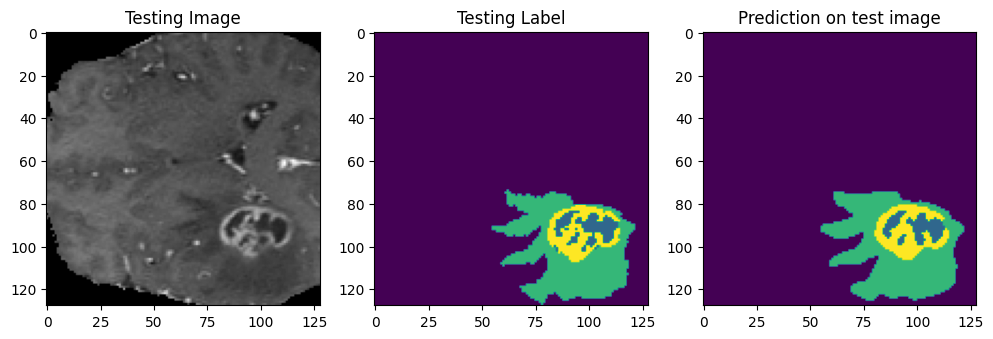

In [91]:
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()